In [9]:
#instalação das bilios direto no jupyter notebook sem venv
%pip install openpyxl
#%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [39]:
import pandas as pd

file_inter_2024 = "../data/raw/BANCO INTER-2024.xlsx"
file_cred_crea_2024 = "../data/raw/BANCO CRED CREA - 2024.xlsx"
file_caixa_2024 = "../data/raw/BANCO CAIXA 2024.xlsx"
file_inter_2023 = "../data/raw/BANCO INTER-2023.xlsx"
file_caixa_2023 = "../data/raw/BANCO CAIXA - 2023.xlsx"
file_cred_crea_2023 = "../data/raw/BANCO CRED CREA - 2023.xlsx"
file_inter_2022 = "../data/raw/BANCO INTER-2022.xlsx"
file_cred_crea_2022= "../data/raw/BANCO CRED CREA -2022.xlsx"
file_caixa_2022 = "../data/raw/BANCO CAIXA - 2022.xlsx"

files = [
    file_inter_2024,
    file_cred_crea_2024,
    file_caixa_2024,
    file_inter_2023,
    file_caixa_2023,
    file_cred_crea_2023,
    file_inter_2022,
    file_cred_crea_2022,
    file_caixa_2022
]

df = pd.read_excel(files[2])
display(df.head())

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,NaN,Extrato CAIXA ECONÔMICA FEDERAL - JAN...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CBEEL
1,NaN,Data Mov.,Nr. Doc.,Histórico,Valor,Saldo,CRÉDITO,DÉBITO,CONTA,SUBCONTA,NaN,NaN
2,NaN,NaN,0,SALDO ANTERIOR,0,"11.539,16 C",NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,2024-01-02 00:00:00,21619,CRED PIX HORFRAN - NF-e 4453,"260,00 C","11.799,16 C",260,NaN,Receita com serviços,NaN,NaN,NaN
4,NaN,2024-01-03 00:00:00,237,CRED TED BRASANITAS HOSPITALAR HIGIEN - NFS-e ...,"585,00 C","12.384,16 C",585,NaN,Receita com serviços,Outras,NaN,NaN


In [40]:
import pandas as pd
import numpy as np
import re
import openpyxl

# Carregar o arquivo Excel

def process_data(file_path):
  df = pd.read_excel(file_path, sheet_name=0)
  if 'CRED CREA' in file_path:
    # Passo 2: Remover linhas que contenham "SALDO ANTERIOR"
    df = df[~df.apply(lambda row: row.astype(str).str.contains('SALDO ANTERIOR', case=False, na=False)).any(axis=1)]

    # Passo 3: Encontrar o cabeçalho correto e redefinir os cabeçalhos
    header_row = df[df.eq('DATA').any(axis=1)].index[0]
    df.columns = df.iloc[header_row]  # Definir a linha do cabeçalho como os nomes das colunas
    df = df[header_row + 1:]  # Excluir a linha do cabeçalho e as linhas acima

    # Passo 4: Resetar o índice e limpar nomes de colunas
    df.reset_index(drop=True, inplace=True)
    df.columns = df.columns.fillna('').str.strip()  # Remover espaços em branco nos nomes das colunas

    # Passo 5: Remover colunas vazias e desnecessárias
    df = df.loc[:, ~df.columns.str.contains('^Unnamed|^\\s*$', regex=True)]

    # Remover linhas que contenham mais de 3 valores NaN (após a exclusão de colunas vazias)
    df = df.dropna(thresh=len(df.columns) - 3)

    df = df[~df.apply(lambda row: row.astype(str).str.contains('DATA', case=False, na=False)).any(axis=1)]

    df['BANCO'] = 'CRED CREA'
    
    df['DÉBITO'] = - df['DÉBITO'] 

  if 'CAIXA' in file_path:
    # Identificar a linha do cabeçalho que contém "Data Mov."
    header_row = df[df.apply(lambda row: row.astype(str).str.contains('Data Mov', case=False, na=False)).any(axis=1)].index[0]
    df.columns = df.iloc[header_row]  # Redefinir o cabeçalho
    df = df[header_row + 1:]  # Excluir linhas acima do cabeçalho

    # Remover colunas que possuem apenas valores NaN ou colunas adicionais irrelevantes
    df = df.dropna(axis=1, how="all")

    # Remover colunas indesejadas com valores específicos irrelevantes como "1303.0"
    df = df.loc[:, ~df.columns.astype(str).str.match('^.*1303.*$')]

    # Remover linhas com "SALDO ANTERIOR"
    df = df[~df.apply(lambda row: row.astype(str).str.contains('SALDO ANTERIOR', case=False, na=False)).any(axis=1)]

    # Renomear colunas para padronizar
    rename_columns = {
        'Data Mov.': 'DATA',
        'Nr. Doc.': 'DOCUMENTO',
        'Histórico': 'DESCRIÇÃO',
        'Valor': 'EXCLUIR',  # Marcar a coluna a excluir
        'Saldo': 'SALDO'
    }
    df.rename(columns=rename_columns, inplace=True)

    # Excluir a coluna "Valor"
    df.drop(columns=['EXCLUIR'], inplace=True, errors='ignore')

    # Limpar strings na coluna SALDO, mantendo apenas números
    df['SALDO'] = df['SALDO'].apply(lambda x: re.sub(r'[^\d.,-]', '', str(x)) if pd.notnull(x) else x)

    if len(df.columns) > 8:  # Se houver colunas extras, assumir que a última é BANCO"
        df['CAIXA'] = df.iloc[:, -1]  # Última coluna não nomeada
        df.drop(columns=[df.columns[-2]], inplace=True)  # Remover a coluna original após mover

    # Remover linhas que contenham mais de 3 valores NaN
    df = df.dropna(thresh=len(df.columns) - 3)

    df = df[~df.apply(lambda row: row.astype(str).str.contains('Data Mov', case=False, na=False)).any(axis=1)]
    # Adicionar o nome do banco
    df['BANCO'] = 'CAIXA'

  if 'INTER' in file_path:

    # Definir a linha correta do cabeçalho
    header_row = 1
    df.columns = df.iloc[header_row]  # Redefinir o cabeçalho
    df = df[header_row + 1:]  # Excluir linhas acima do cabeçalho

    # Resetar o índice após a redefinição do cabeçalho
    df.reset_index(drop=True, inplace=True)

    # Adicionar o nome do banco a partir do nome do arquivo
    df['BANCO'] = "INTER"

    # Remover linhas que contenham "SALDO ANTERIOR" em qualquer coluna
    df = df[~df.apply(lambda row: row.astype(str).str.contains('SALDO ANTERIOR', case=False, na=False)).any(axis=1)]
    # Remover colunas com nome `NaN`
    df = df.loc[:, ~df.columns.isna()]

    # Remover linhas com 3 ou mais valores NaN
    df = df.dropna(thresh=len(df.columns) - 3)

    # Remover linhas que contêm "EXTRATO" ou "DATA LANÇAMENTO" em qualquer coluna
    df = df[~df.apply(lambda row: row.astype(str).str.contains('EXTRATO|DATA LANÇAMENTO', case=False, na=False)).any(axis=1)]

    # Renomear colunas para um formato consistente
    rename_columns = {
        'DATA LANÇAMENTO': 'DATA',
        'HISTÓRICO': 'DESCRIÇÃO',
        'VALOR': 'VALOR',
        'SALDO': 'SALDO'
    }
    df.rename(columns=rename_columns, inplace=True)


    # Limpar e converter a coluna VALOR para numérico, mantendo-a no DataFrame
    df['VALOR'] = df['VALOR'].apply(lambda x: re.sub(r'[^\d.,-]', '', str(x)) if pd.notnull(x) else x)
    df['VALOR'] = df['VALOR'].replace('', '0').str.replace(',', '.').astype(float)

    # Criar colunas de CRÉDITO e DÉBITO a partir da coluna VALOR
    df['CRÉDITO'] = df['VALOR'].apply(lambda x: x if x > 0 else 0)
    df['DÉBITO'] = df['VALOR'].apply(lambda x: -x if x < 0 else 0)

    # Limpar strings da coluna SALDO, mantendo apenas números
    df['SALDO'] = df['SALDO'].apply(lambda x: re.sub(r'[^\d.,-]', '', str(x)) if pd.notnull(x) else x)

    df.drop(columns=['VALOR'], inplace=True)
    df['DOCUMENTO'] = np.nan
  
  if df.dtypes['CRÉDITO'] == 'O':
    df['CRÉDITO'] = df['CRÉDITO'].astype(str)
    df['CRÉDITO'] = df['CRÉDITO'].str.strip()

  if df.dtypes['DÉBITO'] == 'O':
    df['DÉBITO'] = df['DÉBITO'].astype(str)
    df['DÉBITO'] = df['DÉBITO'].str.strip()

  df = df.astype(dtype={'DÉBITO':float, 'CRÉDITO':float})
  df['DATA'] = pd.to_datetime(df['DATA'])
  df = df.reset_index(drop=True)
  
  df = df[['DATA','DESCRIÇÃO','DOCUMENTO','CRÉDITO','DÉBITO',	'SALDO','BANCO', 'CONTA','SUBCONTA']]
  df.loc[::, 'CRÉDITO']= df['CRÉDITO'].fillna(0.0)
  df.loc[::,'DÉBITO']=  df['DÉBITO'].fillna(0.0)

  df['FILE_PATH'] = file_path
  
  return df
display(process_data(file_path=file_caixa_2024))


1,DATA,DESCRIÇÃO,DOCUMENTO,CRÉDITO,DÉBITO,SALDO,BANCO,CONTA,SUBCONTA,FILE_PATH
0,2024-01-02,CRED PIX HORFRAN - NF-e 4453,21619,260.00,0.00,"11.799,16",CAIXA,Receita com serviços,NaN,../data/raw/BANCO CAIXA 2024.xlsx
1,2024-01-03,CRED TED BRASANITAS HOSPITALAR HIGIEN - NFS-e ...,237,585.00,0.00,"12.384,16",CAIXA,Receita com serviços,Outras,../data/raw/BANCO CAIXA 2024.xlsx
2,2024-01-05,ENVIO TEV ROBSON - PAGTO DE SALÁRIO,51237,0.00,2145.47,"10.238,69",CAIXA,Despesa com pessoal,Salário,../data/raw/BANCO CAIXA 2024.xlsx
3,2024-01-05,ENVIO PIX BRENDA - PAGTO DE SALÁRIO,51244,0.00,822.25,"9.416,44",CAIXA,Despesa com pessoal,Salário,../data/raw/BANCO CAIXA 2024.xlsx
4,2024-01-05,ENVIO PIX CINTHYA - PAGTO DE SALÁRIO,51253,0.00,1353.37,"8.063,07",CAIXA,Despesa com pessoal,Salário,../data/raw/BANCO CAIXA 2024.xlsx
...,...,...,...,...,...,...,...,...,...,...
159,2024-08-07,PAG BOLETO VR BENEFICIOS E SERV. DE PROC. - P/...,71627,0.00,200.00,"1.634,50",CAIXA,Despesa com pessoal,Alimentação (VR VA),../data/raw/BANCO CAIXA 2024.xlsx
160,2024-08-07,ENVIO PIX ROBSON-REEMBOLSO DE DESPESAS C/ COMB...,71632,0.00,245.00,"1.389,50",CAIXA,Despesa com pessoal,Alimentação (VR VA),../data/raw/BANCO CAIXA 2024.xlsx
161,2024-08-09,PAG BOLETO CIEE - PAGTO ESTAGIÁRIO KAIO,91131,0.00,550.19,"839,31",CAIXA,Despesa com pessoal,Salário,../data/raw/BANCO CAIXA 2024.xlsx
162,2024-08-12,PAG BOLETO CARTÃO PORTO SEGURO - PEDÁGIOS,121509,0.00,114.73,"724,58",CAIXA,Despesa com serviços,Transporte,../data/raw/BANCO CAIXA 2024.xlsx


In [41]:
df_array = []
for file in files:
    try:
        df = process_data(file)
        df_array.append(df)
        print(f"Processado com sucesso: {file}")
    except Exception as e:
        print(f"Erro ao processar {file}: {e}")
df_concat = pd.concat(df_array)
try:
    df = process_data(file_caixa_2022)
    df_array.append(df)
    print(f"Processado com sucesso: {file_caixa_2022}")
except Exception as e:
    print(f"Erro ao processar {file_caixa_2022}: {e}")

Processado com sucesso: ../data/raw/BANCO INTER-2024.xlsx
Processado com sucesso: ../data/raw/BANCO CRED CREA - 2024.xlsx
Processado com sucesso: ../data/raw/BANCO CAIXA 2024.xlsx
Processado com sucesso: ../data/raw/BANCO INTER-2023.xlsx
Processado com sucesso: ../data/raw/BANCO CAIXA - 2023.xlsx
Processado com sucesso: ../data/raw/BANCO CRED CREA - 2023.xlsx
Processado com sucesso: ../data/raw/BANCO INTER-2022.xlsx
Processado com sucesso: ../data/raw/BANCO CRED CREA -2022.xlsx
Processado com sucesso: ../data/raw/BANCO CAIXA - 2022.xlsx
Processado com sucesso: ../data/raw/BANCO CAIXA - 2022.xlsx


In [42]:


#MOSTRAR AS PRIMEIRAS LINHAS DE 2022 DO BANCO CRED CREA
display(df_concat.loc[(df_concat['DATA'] >= '2024-01-01') & (df_concat['DATA'] <= '2024-12-31') & (df_concat['BANCO'] == 'CAIXA')])



export_path = "../data/processed/df_concat.csv"

#exportar df_concat para csv
df_concat.to_csv(export_path, index=False)

1,DATA,DESCRIÇÃO,DOCUMENTO,CRÉDITO,DÉBITO,SALDO,BANCO,CONTA,SUBCONTA,FILE_PATH
0,2024-01-02,CRED PIX HORFRAN - NF-e 4453,21619,260.00,0.00,"11.799,16",CAIXA,Receita com serviços,NaN,../data/raw/BANCO CAIXA 2024.xlsx
1,2024-01-03,CRED TED BRASANITAS HOSPITALAR HIGIEN - NFS-e ...,237,585.00,0.00,"12.384,16",CAIXA,Receita com serviços,Outras,../data/raw/BANCO CAIXA 2024.xlsx
2,2024-01-05,ENVIO TEV ROBSON - PAGTO DE SALÁRIO,51237,0.00,2145.47,"10.238,69",CAIXA,Despesa com pessoal,Salário,../data/raw/BANCO CAIXA 2024.xlsx
3,2024-01-05,ENVIO PIX BRENDA - PAGTO DE SALÁRIO,51244,0.00,822.25,"9.416,44",CAIXA,Despesa com pessoal,Salário,../data/raw/BANCO CAIXA 2024.xlsx
4,2024-01-05,ENVIO PIX CINTHYA - PAGTO DE SALÁRIO,51253,0.00,1353.37,"8.063,07",CAIXA,Despesa com pessoal,Salário,../data/raw/BANCO CAIXA 2024.xlsx
...,...,...,...,...,...,...,...,...,...,...
159,2024-08-07,PAG BOLETO VR BENEFICIOS E SERV. DE PROC. - P/...,71627,0.00,200.00,"1.634,50",CAIXA,Despesa com pessoal,Alimentação (VR VA),../data/raw/BANCO CAIXA 2024.xlsx
160,2024-08-07,ENVIO PIX ROBSON-REEMBOLSO DE DESPESAS C/ COMB...,71632,0.00,245.00,"1.389,50",CAIXA,Despesa com pessoal,Alimentação (VR VA),../data/raw/BANCO CAIXA 2024.xlsx
161,2024-08-09,PAG BOLETO CIEE - PAGTO ESTAGIÁRIO KAIO,91131,0.00,550.19,"839,31",CAIXA,Despesa com pessoal,Salário,../data/raw/BANCO CAIXA 2024.xlsx
162,2024-08-12,PAG BOLETO CARTÃO PORTO SEGURO - PEDÁGIOS,121509,0.00,114.73,"724,58",CAIXA,Despesa com serviços,Transporte,../data/raw/BANCO CAIXA 2024.xlsx


In [14]:
df_concat['ANO'] = df_concat['DATA'].dt.year
df_saldo_ano  = df_concat.groupby('ANO').agg(total_credito = ('CRÉDITO',sum),
                             total_debito = ('DÉBITO', sum))
df_saldo_ano['LÍQUIDO'] = df_saldo_ano['total_credito'] - df_saldo_ano['total_debito'] 
df_saldo_ano

C:\Users\fcoan\AppData\Local\Temp\ipykernel_32936\59700262.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_saldo_ano  = df_concat.groupby('ANO').agg(total_credito = ('CRÉDITO',sum),


,total_credito,total_debito,LÍQUIDO
ANO,,,
2022,543331.98,559898.01,-16566.03
2023,690034.98,680045.09,9989.89
2024,200150.50,203797.55,-3647.05


## Início da Análise exploratória

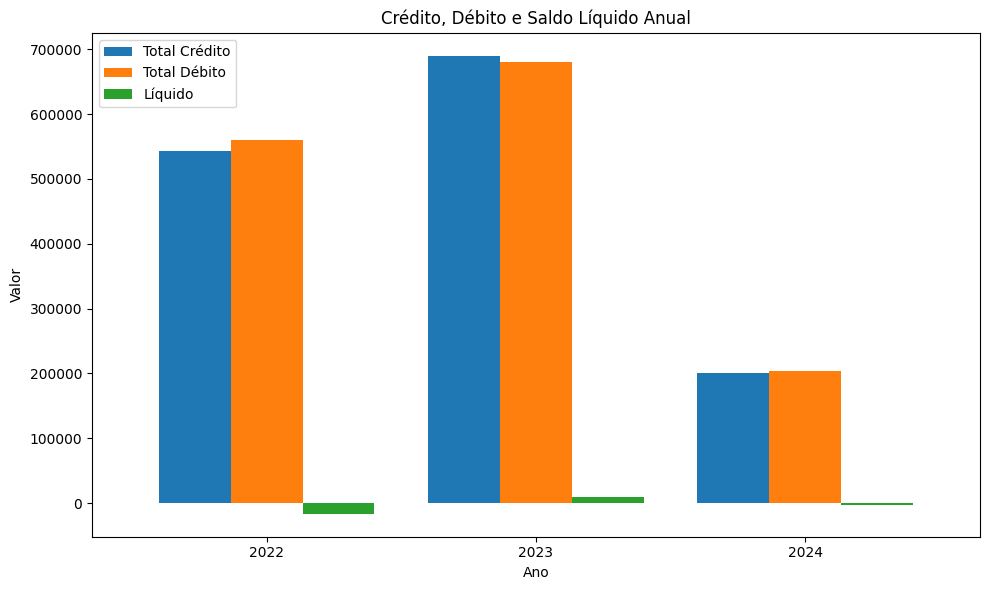

In [15]:
import matplotlib.pyplot as plt

# Criando o gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))
df_saldo_ano[['total_credito', 'total_debito', 'LÍQUIDO']].plot(
    kind='bar', ax=ax, width=0.8, rot=0
)

# Configurações do gráfico
plt.title('Crédito, Débito e Saldo Líquido Anual')
plt.xlabel('Ano')
plt.ylabel('Valor')
plt.legend(['Total Crédito', 'Total Débito', 'Líquido'], loc='upper left')
plt.tight_layout()

plt.show()